In [1]:
from wmf import wmf
import matplotlib as _matplotlib
import matplotlib.pyplot as _plt
import datetime as _datetime
import numpy as np
import pandas as pd
import os
from netCDF4 import Dataset

##Réplica del MSI oficial, con el cambio que se le puede ingresar la fecha que se quiere modelar, si no se ingresa nada
## en la fecha se correrá el modelo con la hora y el día actual.
## A parte no necesita ingresar argumentos de rutas porque ya tiene todas las rutas específicadas en su interior, si se 
## especifican es porque son rutas diferentes a las que tenemos establecidas

## SOLO SE MODIFICÓ EL __INIT__ Y EL GENERAR_MAPAS_TEMPERATURAS
class msi_2(wmf.SimuBasin):
    '''Clase para utilizar las funciones de graficacion, ejecucion y lectura de resultados 
    del modelo de susceptibilidad a incendios en cobertura vegetal (MSI), por medio del 
    modelo de cuenca WMF.
    '''
    
    def __init__(self, ruta_nc = None, ruta_lluvia = None, ruta_coberturas = None, ruta_estatico = None, ruta_historicos = None, 
                 ruta_humedad = None, ruta_font = None, ruta_temp = None, fecha = None):
        '''
        Inicia un objeto para utilizar las funciones de graficacion, ejecucion y lectura de resultados del modelo de susceptibilidad a incendios en cobertura vegetal (MSI)
        
        Parametros
        ----------
        ruta_nc         : Ruta para cargar la cuenca de wmf guardada en formato nc
        
        Opcionales:
        ----------
        ruta_lluvia     : Ruta donde se almacenan los binarios de lluvia en formato nc (.nc)
        ruta_coberturas : Ruta donde se almacena el mapa de coberturas del suelo de la cuenca
        ruta_estatico   : Ruta donde se almacenan las variables estaticas del modelo (coberturas y buffer urbano)
        ruta_historico  : Ruta donde se almacena el hisotrico de susceptibilidad calculada (.bin o .hdr)
        '''
        
        import pathlib
        import os

        #ruta = pathlib.Path(__file__).parent.absolute()
        #ruta = str(ruta)
        #print(ruta)
        
        self.fecha = _datetime.datetime.now() if fecha is None else fecha
        self.fecha_utc = self.fecha + _datetime.timedelta(hours=5)
        print(self.fecha)
        ## ESTA RUTA SE PONE SOLO MIENTRAS HAGO LAS PRUEBAS, LUEGO ES SOLO DESCOMENTAR LAS 3 LÍNEAS DE ARRIBA
        ruta = "/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/SIATA_incendios/modelo_susceptibilidad"
        self.ruta_temp = "/mnt/t2_matriz/T2_" if ruta_temp is None else ruta_temp
        
        self.ruta_nc = ruta_nc if ruta_nc is not None else ruta + '/src/cuenca_amva_incendios_90m_py3.nc'
        self.ruta_lluvia = "/var/radar/operacional/" if ruta_lluvia is None else ruta_lluvia
        self.ruta_humedad = '/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1h/SHop/project_files/results/results_op/Sto_op-p01-ci2-1d' if ruta_humedad is None else ruta_humedad
        self.ruta_coberturas = ruta_coberturas
        self.ruta_urbano = ruta + '/src/urbano_90m.csv'
        self.ruta_historicos =  ruta + '/src/mapa_historico.csv' if ruta_historicos is None else ruta_historicos
        self.ruta_estatico = ruta + '/src/mapa_estatico.csv' if ruta_estatico is None else ruta_estatico
        self.ruta_font = ruta + '/src/AvenirLTStd-Book/' if ruta_font == None else ruta_font
        self.reglas_temperatura = pd.DataFrame.from_dict({'P10': {15.513333333333321: np.nan,17.07343644781144: 14.426766967773437,18.633539562289556: 16.9803955078125,20.193642676767674: 17.69061279296875,21.75374579124579: 18.391046142578126,23.31384890572391: 19.539630126953124,24.873952020202026: 20.755718994140622,26.434055134680143: 23.872222900390625,27.99415824915826: 26.30636291503906},'P25': {15.513333333333321: np.nan,17.07343644781144: 16.92670440673828,18.633539562289556: 19.413726806640625,20.193642676767674: 19.893829345703125,21.75374579124579: 20.49463653564453,23.31384890572391: 21.296524047851562,24.873952020202026: 22.79302215576172,26.434055134680143: 25.769439697265625,27.99415824915826: 29.70972442626953},'P50': {15.513333333333321: np.nan,17.07343644781144: 19.597320556640625,18.633539562289556: 22.176239013671875,20.193642676767674: 22.278076171875,21.75374579124579: 23.805648803710938,23.31384890572391: 23.968170166015625,24.873952020202026: 25.447097778320312,26.434055134680143: 28.303802490234375,27.99415824915826: 33.257781982421875},'P75': {15.513333333333321: np.nan,17.07343644781144: 22.75951385498047,18.633539562289556: 24.477142333984375,20.193642676767674: 25.048355102539062,21.75374579124579: 26.9501953125,23.31384890572391: 27.576751708984375,24.873952020202026: 28.499366760253906,26.434055134680143: 31.187835693359375,27.99415824915826: 35.788612365722656},'P90': {15.513333333333321: np.nan,17.07343644781144: 24.9921875,18.633539562289556: 26.133477783203134,20.193642676767674: 27.5667724609375,21.75374579124579: 29.506164550781254,23.31384890572391: 30.279193115234374,24.873952020202026: 31.127844238281252,26.434055134680143: 33.75217895507813,27.99415824915826: 37.69429931640625}})

        wmf.SimuBasin.__init__(self, rute = self.ruta_nc)
        self.GetGeo_Cell_Basics()
        
        self.mapa_historico = pd.read_csv(self.ruta_historicos, index_col = None).values.reshape(-1)
        self.mapa_estatico = pd.read_csv(self.ruta_estatico, index_col = None).values.reshape(-1)
        print(self.mapa_historico.mean())
        #------------------------------------------
        #Generar cmap del modelo de susceptibilidad
        #------------------------------------------
        
        import matplotlib.colors as mcolors
        def make_colormap(seq):
            seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
            cdict = {'red': [], 'green': [], 'blue': []}
            for i, item in enumerate(seq):
                if isinstance(item, float):
                    r1, g1, b1 = seq[i - 1]
                    r2, g2, b2 = seq[i + 1]
                    cdict['red'].append([item, r1, r2])
                    cdict['green'].append([item, g1, g2])
                    cdict['blue'].append([item, b1, b2])
            return mcolors.LinearSegmentedColormap('CustomMap', cdict)

        r1=98/255. ; g1=210/255. ; b1=221/255. ; r2=63/255. ; g2=125/255. ; b2=170/255.
        r3=237/255. ; g3=226/255. ; b3=20/255. ; r4=214/255. ; g4=30/255. ; b4=30/255.
        rvb = make_colormap([(r1,g1,b1), 0.25, (r2,g2,b2), 0.50, (r3,g3,b3), 0.75, (r4,g4,b4)])
        #rvb = make_colormap([(r1,g1,b1), 0.01, (r2,g2,b2), 0.22, (r3,g3,b3), 0.38, (r4,g4,b4)])
       # umbs = [0,0.1,0.22,0.38,0.95]
        self.colores_modelo = rvb

        #-----------------------------------------
        #Ajustar el font predeterminado por Avenir
        #-----------------------------------------
        try:
            import matplotlib.font_manager as font_manager
            font_dirs = [self.ruta_font]
            font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
            font_list = font_manager.createFontList(font_files)
            font_manager.fontManager.ttflist.extend(font_list)
            _matplotlib.rcParams['font.family'] = 'Avenir LT Std'
            _matplotlib.rcParams['font.size'] = 13
            print('Usando font Avenir')
        except:
            print('Usando font por defecto')
            pass
        
    def __repr__(self):
        info = '''
        Modelo de susceptibilidad de incendios en cobertura vegetal, MSI. (Zapata, Velasquez, Hoyos, Ospina. 2017)
        Grupo hidrología. SIATA

        Explicación del modelo
        '''
        return info
    ## Función de humedad
    def generar_mapa_humedad(self, umbrales_humedad = [0,100,150,200,250,300,350,400,100000000], probabilidad_humedad = [0.9,0.9,0.8,0.7,0.5,0.15,0.05,0]):
        #Lectura de la cuenca
        self.cu = wmf.SimuBasin(rute= self.ruta_nc)
        #path = ruta_humedad
        f=open(self.ruta_humedad+'.StOhdr', newline="\n")
        filelines=f.readlines()
        f.close()
        IDs=np.array([int(i.split(',')[0]) for i in filelines[5:]])
        fechas=np.array([(i.split(',')[-1]) for i in filelines[5:]])
        fechas = [i.strip() for i in fechas]
        fecha_str_h = self.fecha.strftime("%Y-%m-%d-%H:%M")
        if self.fecha < _datetime.datetime(2021,1,1):
            ind = fechas.index(fecha_str_h)
            self.mapa_humedad, self.R = wmf.models.read_float_basin_ncol(self.ruta_humedad + '.StObin',ind, self.cu.ncells, 5)
        else:
            self.mapa_humedad, self.R = wmf.models.read_float_basin_ncol(self.ruta_humedad + '.StObin',len(IDs), self.cu.ncells, 5)
        
        self.mapa_humedad = self.mapa_humedad[0] + self.mapa_humedad[2]
        
        for i, probabilidad in enumerate(probabilidad_humedad):
            self.mapa_humedad[(self.mapa_humedad >= umbrales_humedad[i])&(self.mapa_humedad <= umbrales_humedad[i + 1])] = probabilidad_humedad[i]
        
        return self.mapa_humedad
    
    
    #Funciones temperatura
    
    def generar_mapa_temperaturas(self, temperatura_wrf= None, reglas_temperatura = None, percentil_reglas = 'P75', prop = [135, 135, -76.77193450927734, 5.008949279785156, 0.0179290771484375, 0.01798248291015625, -9999]):
        '''
        Genera un mapa de temperatura superficial para la cuenca, a partir de un archivo (txt) o directamente una matriz que contenga la temperatura supeficial estimada por el modelo WRF, además en caso de no asignar las matrices de longitudes y latitudes correpsondientes, se asumen los valores por defecto de todo el dominio D03 del modelo de pronostico.
        
        Parametros
        ----------
        temperatura_wrf : Ruta para cargar el archivo de texto que contiene la temperatura superficial de wrf, alternativamente se puede ingresar directmente una matriz
        
        Opcionales:
        ----------
        fecha           : Día 
        reglas          : Ruta al archivo msgpack que contenga las reglas de temepratura para hacer el ajuste por elevacion de la temperatura ambiente del modelo, para convertirla a temperatura del suelo, alternativamnete se puede ingresar directamente un dataframe con esta informacion, si se deja este argumento como None se utilizan las reglas por defecto
        percentil_reglas: Dado que la reglas de temperatura corresponde a una conversion de temperatura ambiente a superificial, por medio de un ajuste de cuantiles por intervalos, se debe escoger el cuantil, con que se realizara la conversión, por defecto se utiliza el P75, luego de una evalución del optimalidad para representar la variacion diurna de la susceptibilidad
        prop            : Propiedades del mapa de temperatura wrf -> [ncolumnas, nfilas, xll, yll, dx, dy, no_data]
        '''
        
        #cargado de las reglas de temperatura
        if reglas_temperatura == None:
            pass
        elif isinstance(reglas_temperatura, pd.DataFrame):
            self.reglas_temperatura = reglas_temperatura
        elif type(reglas_temperatura) == str:
            self.reglas_temperatura  = pd.read_msgpack(reglas_temperatura)
        else:
            raise Exception('Entrada no valida para las reglas de temperatura')
            
        self.hoy = _datetime.datetime.strftime(self.fecha, "%Y-%m-%d_%H") # Poner la fecha en el formato con que se guardan los archivos
        self.hoy_utc = _datetime.datetime.strftime(self.fecha_utc, "%Y-%m-%d_%H")
        print(self.hoy)
        ## Llamar mi mapa del día en cuestión, si la persona no especifica fecha se usa la quetiene por defecto 
        self.temperatura_wrf = self.ruta_temp + str(self.hoy_utc) +"_05"  if temperatura_wrf is None else temperatura_wrf
        
        #cargado de la temperatura
        if type(self.temperatura_wrf) == str:
            self.mapa_temperatura_ambiente = pd.read_csv(self.temperatura_wrf, header=None, delim_whitespace=True).values[::-1].T
        elif type(self.temperatura_wrf) == np.ndarray:
            self.mapa_temperatura_ambiente = self.temperatura_wrf[::-1].T
        elif isinstance(self.temperatura_wrf, pd.DataFrame):
            self.mapa_temperatura_ambiente = self.temperatura_wrf.values[::-1].T
        elif isinstance(self.temperatura_wrf, list):
            self.mapa_temperatura_ambiente = np.array(self.temperatura_wrf)[::-1].T
        else:
            raise Exception('Entrada no valida para temperatura_wrf, debe ser un array, una lista o un DataFrame')
        
        self.__prop_temperatura__ = prop
        
        self.mapa_temperatura_ambiente = self.Transform_Map2Basin(self.mapa_temperatura_ambiente, self.__prop_temperatura__)
        self.mapa_temperatura_ambiente = self.mapa_temperatura_ambiente - 273.15 if self.mapa_temperatura_ambiente.mean() > 100 else self.mapa_temperatura_ambiente
        
        #Se utiliza un arbol binario para seleccionar las alturas y temperaturas al interior del valle para ralizar el ajuste de temperatura por altura
        from scipy import spatial

        coordsX = wmf.cu.basin_coordxy(self.structure,self.ncells)[0] #longitudes del mapa
        coordsY = wmf.cu.basin_coordxy(self.structure,self.ncells)[1] #latitudes del mapa

        tree = spatial.cKDTree(list(zip(coordsX, coordsY)))

        lons, lats = np.meshgrid(prop[2] + np.arange(prop[0]) * prop[4], prop[3] + np.arange(prop[1]) * prop[5])
        lons, lats = lons.ravel(), lats.ravel()
        distancias, indices = tree.query(list(zip(lons, lats)), distance_upper_bound= .084/111)


        pol = np.poly1d(np.polyfit(self.CellHeight[indices[np.isfinite(distancias)]], self.mapa_temperatura_ambiente[indices[np.isfinite(distancias)]], 1))
        
        self.mapa_temperatura_ambiente = pol(self.CellHeight)
        self.mapa_temperatura_superficial = np.zeros_like(self.mapa_temperatura_ambiente)
        
        self.__ajuste_temperatura_ambiente__ = (self.reglas_temperatura.index[:-1] + self.reglas_temperatura.index[1:])/2
        self.__ajuste_temperatura_superficial__ = self.reglas_temperatura.loc[:, percentil_reglas].dropna().values
        
        idx = (self.mapa_temperatura_ambiente < self.__ajuste_temperatura_ambiente__[0])
        self.mapa_temperatura_superficial[idx] =  np.poly1d(np.polyfit(self.__ajuste_temperatura_ambiente__[:2], self.__ajuste_temperatura_superficial__[:2], 1))(self.mapa_temperatura_ambiente[idx])

        for limite_inferior, limite_superior, inferior, superior in zip(self.__ajuste_temperatura_ambiente__[:-1], self.__ajuste_temperatura_ambiente__[1:], self.__ajuste_temperatura_superficial__[:-1], self.__ajuste_temperatura_superficial__[1:]):
            idx = (self.mapa_temperatura_ambiente >= limite_inferior) & (self.mapa_temperatura_ambiente < limite_superior) 
            self.mapa_temperatura_superficial[idx] =  np.poly1d(np.polyfit([limite_inferior, limite_superior], [inferior, superior], 1))(self.mapa_temperatura_ambiente[idx])

        idx = (self.mapa_temperatura_ambiente >= self.__ajuste_temperatura_ambiente__[-1])
        self.mapa_temperatura_superficial[idx] =  np.poly1d(np.polyfit(self.__ajuste_temperatura_ambiente__[-2:], self.__ajuste_temperatura_superficial__[-2:], 1))(self.mapa_temperatura_ambiente[idx])

        return self.mapa_temperatura_superficial
    
    def generar_mapa_lluvia(self, lluvia_radar = None, fecha_inicio = None, fecha_fin = None, dias_acumulado = 10, umbral_sequia = 6, prop = [1728, 1728, -76.82, 4.9, 0.0015, 0.0015, 999999]):
        '''
        Genera un mapa de lluvia de radar para la cuenca y un mapa de sequia (ver definicion de mapa de sequia en la documentacion del modelo), a partir de indicar la fecha de inicio y de fin, para el caso en que se lea la lluvia de radar de una carpeta con archivos netcdf de lluvia de radar (para esto se requiere haber ingresado una ruta a self.ruta_lluvia). Ademas se pueden ingresar matrices con la lluvia siempre y cuando se agrege la lista de atributos de esta para reconstruir las longitudes y latitudes, en el argumento prop, como se muestra en la lista de parametros de la funcion desritos a continuacion:
        
        Parametros 
        ----------
        lluvia_radar    : Ruta para cargar el archivo que contiene la lluvia de radar acumulada, alternativamente se puede ingresar directmente un array (1D si se trata de un vector de cuenca o 2D si se ajusta el parametro prop para que wmf pueda cargar esta matriz como vector de cuenca), en caso de tratarse de un archivo este puede ser un archivo .nc, para otros formatos se recomienda cargarlos de forma externa y cargarlos en un array de numpy. Se recomienda dejar como None e ingresar la fecha de inicio y final para que a partir de los archivos netcdf con acumulados de radar se acumule la lluvia. 
        fecha_fin       : Si se ha creado una instancia del modelo ingresando la ruta de la carpeta con los archivos .nc de acumulados de lluvia se puede escoger una fecha de inicio y una fecha de fin para acumular la lluvia de todos los archvios entre estas fechas. Este argumento puede ser None y solo escoger un valor para fecha_fin y una cantidad de dias para acumular la lluvia antecedente a dicha fecha.
        fecha_inicio    : Si se ha creado una instancia del modelo ingresando la ruta de la carpeta con los archivos .nc de acumulados de lluvia se puede escoger una fecha de inicio y una fecha de fin para acumular la lluvia de todos los archvios entre estas fechas. Este argumento puede ser None y solo escoger un valor para fecha_fin y una cantidad de dias para acumular la lluvia antecedente a dicha fecha.
        dias_acumualdo  : Si se utilizan fechas para acumular la lluvia, se puede escoger una cantidad de dias de lluvia antecedente y solo asignar una fecha_fin para acumular la lluvia hacia atras de dicha fecha
        umbral_sequia   : Para generar el mapa de dias de sequia se escoge un umbral por debajo del cual se considera que en un pixel se presento una condicion de sequia, el valor se escoge en milimetros de columna de agua
        
        Opcionales:
        ----------
        prop            : Propiedades del mapa de lluvia -> [ncolumnas, nfilas, xll, yll, dx, dy, no_data]
        '''
        
        #cargado de la lluvia mediante un archivo nc de radar 
        if (type(lluvia_radar) == str)&(str(lluvia_radar[:]).split('.')[-1] == 'nc'):
            datos = Dataset(lluvia_radar)
            self.mapa_lluvia_radar = self.Transform_Map2Basin(datos.variables['Rain'][:].T / (12*1000), prop)
            datos.close()
        
        #cargado de la lluvia mediante un lista de archivos nc de radar 
        if (len(lluvia_radar) > 0)&(len(np.array(lluvia_radar).shape) == 1)&(pd.Series(lluvia_radar).apply(lambda x: x.split('.')[-1]).dropna().drop_duplicates().isin(['nc']).replace(False, np.nan).dropna().size):
            lluvia_radar = sorted(lluvia_radar)[::-1]
            self.mapa_lluvia_radar = np.zeros(self.ncells)
            hora = _datetime.datetime.now()
            print('Acumulando lluvia, esto puede tardar unos minutos')
            
            fechas_archivos = pd.Series(lluvia_radar).apply(lambda ruta: pd.to_datetime(ruta.split('/')[-1].split('_')[0], format = '%Y%m%d%H%M'))
            for ruta in list(lluvia_radar):
                try:
                    datos = Dataset(ruta)
                    self.mapa_lluvia_radar = self.mapa_lluvia_radar + self.Transform_Map2Basin(datos.variables['Rain'][:].T / (12*1000), prop)
                    datos.close()
                except:
                    print('Archivo no valido:', ruta)
                    
            print('Acumular la lluvia ha tardado:', _datetime.datetime.now() - hora)
            
        ## Cargando la lluvia desde los archivos de 5 minutos generados por el radar .nc            
        if os.path.isdir(lluvia_radar)&(fecha_inicio != None)&(fecha_fin != None):
            
            from glob import glob
            
            fecha_inicio = pd.to_datetime(fecha_inicio) + pd.Timedelta('5h')
            fecha_fin = pd.to_datetime(fecha_fin) + pd.Timedelta('5h')
            ruta_radar = lluvia_radar
            dias = pd.date_range(fecha_inicio, fecha_fin, freq = '1d')
            lluvia_radar = np.concatenate([glob(lluvia_radar + '/' + dia.strftime('%Y%m%d') + '*') for dia in dias])
            lluvia_radar = np.sort(lluvia_radar, kind = 'qsort')
            lluvia_radar = pd.Series(lluvia_radar).apply(lambda ruta: pd.to_datetime(ruta.split('/')[-1].split('_')[0], format = '%Y%m%d%H%M'))
            lluvia_radar = lluvia_radar[(lluvia_radar >= fecha_inicio)&(lluvia_radar <= fecha_fin)]
            lluvia_radar = [ruta_radar + '/' + fecha.strftime('%Y%m%d%H%M') + '_010_120.nc' for fecha in lluvia_radar]
            rutas = list(lluvia_radar)[::-1]
            
            self.mapa_lluvia_radar = np.zeros(self.ncells)
            mapa_tiempo_sequia = np.zeros(self.ncells)
            hora = _datetime.datetime.now()
            print('Acumulando lluvia, esto puede tardar unos minutos')
            
            fecha_maxima = pd.to_datetime(rutas[np.argmax([int(i.split('/')[-1].split('_')[0]) for i in rutas])].split('/')[-1].split('_')[0], format = '%Y%m%d%H%M')
            print(fecha_maxima)
            for ruta in rutas:
                fecha = pd.to_datetime(ruta.split('/')[-1].split('_')[0], format = '%Y%m%d%H%M')
                try:
                    datos = Dataset(ruta)
                    self.mapa_lluvia_radar = self.mapa_lluvia_radar + self.Transform_Map2Basin(datos.variables['Rain'][:].T / (12*1000), prop)
                    
                    f = fecha_maxima - fecha
                    mapa_tiempo_sequia[self.mapa_lluvia_radar < 6] = f.components.days + f.components.hours/24 + f.components.minutes/(24 * 60)
                    
                    datos.close()
                
                except:
                    print('Archivo no valido:', ruta)
                
            self.mapa_tiempo_sequia = mapa_tiempo_sequia
                    
            print('Acumular la lluvia ha tardado:', _datetime.datetime.now() - hora)
            
            
        else:
            raise Exception('Entrada no valida para lluvia_radar, debe ser un array, una ruta a un archivo nc de lluvia acumulada, una lista de rutas de nc o la ruta a la carpeta que contiene dichos archivos indicando fecha inicio y fecha fin para obetner los acumulados')
        
        print('Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia')
        return self.mapa_lluvia_radar
    
    def generar_mapa_lluvia_probabilidad(self, lluvia_radar = None, fecha_inicio = None, fecha_fin = None, dias_acumulado = 7, umbral_sequia = 6, umbrales_acumulados = [0,30,60,90,120,150,500], probabilidad_acumulados = [0.58,0.25,0.2,0.08,0.05,0.02], umbrales_dias_sequia = [4, 7], prop = [1728, 1728, -76.82, 4.9, 0.0015, 0.0015, 999999]):
        
        '''
        Genera un mapa de de probabilidad a la ocurrencia de incendios debido a la lluvia de radar y los días de sequia antecedentes para la cuenca 
        
        Parametros 
        ----------
        lluvia_radar    : Ruta para cargar el archivo que contiene la lluvia de radar acumulada, alternativamente se puede ingresar directmente un array (1D si se trata de un vector de cuenca o 2D si se ajusta el parametro prop para que wmf pueda cargar esta matriz como vector de cuenca), en caso de tratarse de un archivo este puede ser un archivo .nc, para otros formatos se recomienda cargarlos de forma externa y cargarlos en un array de numpy. Se recomienda dejar como None e ingresar la fecha de inicio y final para que a partir de los archivos netcdf con acumulados de radar se acumule la lluvia. 
        fecha_fin       : Si se ha creado una instancia del modelo ingresando la ruta de la carpeta con los archivos .nc de acumulados de lluvia se puede escoger una fecha de inicio y una fecha de fin para acumular la lluvia de todos los archvios entre estas fechas. Este argumento puede ser None y solo escoger un valor para fecha_fin y una cantidad de dias para acumular la lluvia antecedente a dicha fecha.
        fecha_inicio    : Si se ha creado una instancia del modelo ingresando la ruta de la carpeta con los archivos .nc de acumulados de lluvia se puede escoger una fecha de inicio y una fecha de fin para acumular la lluvia de todos los archvios entre estas fechas. Este argumento puede ser None y solo escoger un valor para fecha_fin y una cantidad de dias para acumular la lluvia antecedente a dicha fecha.
        dias_acumualdo  : Si se utilizan fechas para acumular la lluvia, se puede escoger una cantidad de dias de lluvia antecedente y solo asignar una fecha_fin para acumular la lluvia hacia atras de dicha fecha
        umbral_sequia   : Para generar el mapa de dias de sequia se escoge un umbral por debajo del cual se considera que en un pixel se presento una condicion de sequia, el valor se escoge en milimetros de columna de agua
        
        Opcionales:
        ----------
        prop            : Propiedades del mapa de lluvia -> [ncolumnas, nfilas, xll, yll, dx, dy, no_data]
        '''
        
        
        
        self.generar_mapa_lluvia(lluvia_radar = lluvia_radar, fecha_inicio = fecha_inicio, fecha_fin = fecha_fin, dias_acumulado = dias_acumulado, umbral_sequia = umbral_sequia)
        
        mapa_probabilidad_acumulados = np.zeros_like(self.mapa_lluvia_radar)
        mapa_probabilidad_sequia = np.zeros_like(self.mapa_lluvia_radar)
        
        for i, probabilidad in enumerate(probabilidad_acumulados):
            mapa_probabilidad_acumulados[(self.mapa_lluvia_radar >= umbrales_acumulados[i])&(self.mapa_lluvia_radar <= umbrales_acumulados[i + 1])] = probabilidad_acumulados[i]
            
        
        #zona naranja
        mapa_probabilidad_sequia[np.where((self.mapa_tiempo_sequia >= 0)&(self.mapa_tiempo_sequia <= 4)&(self.mapa_lluvia_radar >= umbrales_acumulados[0])&(self.mapa_lluvia_radar < umbrales_acumulados[3]))[0]] = 1.4
        #zona roja
        mapa_probabilidad_sequia[np.where((self.mapa_tiempo_sequia >= 4)&(self.mapa_tiempo_sequia <= 7)&(self.mapa_lluvia_radar >= umbrales_acumulados[0])&(self.mapa_lluvia_radar < umbrales_acumulados[1]))[0]] = 1.5
        #zona amarilla
        mapa_probabilidad_sequia[np.where((self.mapa_tiempo_sequia >= 4)&(self.mapa_tiempo_sequia <= 7)&(self.mapa_lluvia_radar >= umbrales_acumulados[1])&(self.mapa_lluvia_radar < umbrales_acumulados[3]))[0]] = 1.2
        #zona azul
        mapa_probabilidad_sequia[np.where((self.mapa_tiempo_sequia >= 0)&(self.mapa_tiempo_sequia <= 7)&(self.mapa_lluvia_radar >= umbrales_acumulados[3]))[0]] = 1

        self.mapa_probabilidad_lluvia = mapa_probabilidad_acumulados * mapa_probabilidad_sequia
            
        return self.mapa_probabilidad_lluvia
    
    def generar_mapa_final(self):
        '''
        Genera un mapa de de porbabilidad a la ocurrencia de incendios teniendo en cuenta la lluvia precedente, la humedad y temperatura del suelo y otros parámetros históricos
        
        Parametros 
        ----------
        temperatura_wrf    : Ruta para cargar el archivo que contiene la temperatura del aire generada por el model WRF
        
        Opcionales:
        ----------
        prop            : Propiedades del mapa de lluvia -> [ncolumnas, nfilas, xll, yll, dx, dy, no_data]
        '''
        
        Hum = self.generar_mapa_humedad()
        Temp = self.generar_mapa_temperaturas()
        Rain = self.generar_mapa_lluvia_probabilidad(self.ruta_lluvia, self.fecha -
                                                      _datetime.timedelta(days=7),self.fecha)
        mask_temp = np.zeros_like(self.mapa_estatico)
        mask_temp[np.where(Temp >22)[0]] = 1
        ## Coeficientes:
        Wr=0.45 ; Wh=0.22 ; We=0.14 ; Whist=0.19
        self.mapa_final = (Wr*Rain)+ (We*self.mapa_estatico) + (Whist*self.mapa_historico) + (Wh*Hum)
        self.mapa_final = self.mapa_final*mask_temp
        mascara=pd.read_csv(self.ruta_urbano,header=None, dtype=int).values
        self.mapa_final_urban= self.mapa_final.copy()
        mascara = mascara.reshape(mascara.shape[0])
        self.mapa_final_urban[mascara]=None
        return self.mapa_final, self.mapa_final_urban
          

No se logra importar basemap, por lo tanto no funciona Plot_basin


In [2]:
model = msi_2()#,  fecha=datetime.datetime(2020,2,15))

2021-11-05 14:50:51.413328
0.007704249663185708
Usando font Avenir


<ipython-input-1-617caee1feff>:100: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [3]:
m1,m2 = model.generar_mapa_final()

2021-11-05_14
Acumulando lluvia, esto puede tardar unos minutos
2021-11-05 19:43:00
Acumular la lluvia ha tardado: 0:02:19.119351
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia


In [4]:
model.mapa_lluvia_radar

array([44.11316657, 43.75424999, 34.01508331, ..., 80.58208345,
       78.00841643, 80.58208345])

In [158]:
ruta_humedad_hist = "/mnt/SH_medioanoplazo/bin_storage_1h_v2/E260_1h_90m_2017_2020"
#ruta_humedad_hist = "/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1h/SHop/project_files/results/results_op/Sto_op-p01-ci2-1d"

In [193]:
mapa_historico = pd.read_csv(model.ruta_historicos, index_col = None).values.reshape(-1)


In [194]:
mapa_historico

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -5.8710003e+32, -5.8710003e+32,  0.0000000e+00])

In [202]:
str(fechas_otromodelo[0].date())

'2021-01-01'

In [5]:
model2 = msi_2(ruta_estatico="/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/Mapas_nuevos/Mapa_estatico2.csv",
                 ruta_historicos="/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/Mapas_nuevos/heat_historico.csv")

2021-10-19 14:33:35.145104
0.08605569402708732
Usando font Avenir


<ipython-input-1-617caee1feff>:100: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [6]:
s1,s2 = model2.generar_mapa_final()

2021-10-19_14
Acumulando lluvia, esto puede tardar unos minutos
2021-10-19 19:28:00
Acumular la lluvia ha tardado: 0:02:22.892911
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia


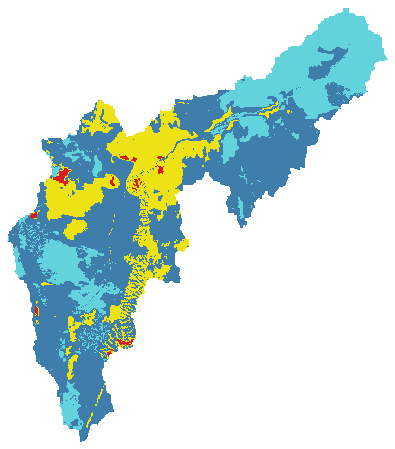

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [9]:
model.Plot_basinClean(s1, cmap=model.colores_modelo)

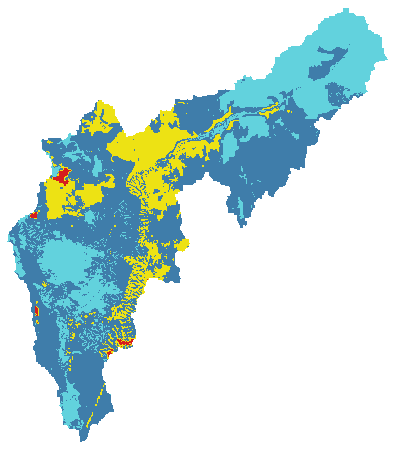

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [10]:
model.Plot_basinClean(m1, cmap=model.colores_modelo)

In [189]:
model.generar_mapa_final()

Acumulando lluvia, esto puede tardar unos minutos
2021-01-01 18:55:00
Acumular la lluvia ha tardado: 0:02:45.194607
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia


(array([0.1474504, 0.2374504, 0.2374504, ..., 0.3915   , 0.3915   ,
        0.3915   ]),
 array([0.1474504, 0.2374504, 0.2374504, ..., 0.3915   , 0.3915   ,
        0.3915   ]))

In [2]:
fechas_otromodelo = pd.date_range("2021-01-04 14:00", "2021-09-03 14:00", freq="1d")
fechas_otromodelo

DatetimeIndex(['2021-01-04 14:00:00', '2021-01-05 14:00:00',
               '2021-01-06 14:00:00', '2021-01-07 14:00:00',
               '2021-01-08 14:00:00', '2021-01-09 14:00:00',
               '2021-01-10 14:00:00', '2021-01-11 14:00:00',
               '2021-01-12 14:00:00', '2021-01-13 14:00:00',
               ...
               '2021-08-25 14:00:00', '2021-08-26 14:00:00',
               '2021-08-27 14:00:00', '2021-08-28 14:00:00',
               '2021-08-29 14:00:00', '2021-08-30 14:00:00',
               '2021-08-31 14:00:00', '2021-09-01 14:00:00',
               '2021-09-02 14:00:00', '2021-09-03 14:00:00'],
              dtype='datetime64[ns]', length=243, freq='D')

In [ ]:
import modelo_susceptibilidad
from wmf import wmf
import numpy as np
import datetime
import pandas as pd

path = "/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/SIATA_incendios/operacional/Resultados_otrosmapas/"
fecha_dt=datetime.datetime.now()
hoy = datetime.datetime.strftime(fecha_dt, "%Y-%m-%d_%H")
hoy_utc = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d_%H")
for i in fechas_otromodelo:
    
    ###Genero un objeto de mi clase msi que es con el que voy a hacer todo
    model = msi_2(fecha=i, ruta_estatico="/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/Mapas_nuevos/Mapa_estatico2.csv",
                 ruta_historicos="/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/Mapas_nuevos/heat_historico.csv")

    mapa_final, mapa_final_urban = model.generar_mapa_final()

    mapa_final = pd.DataFrame(mapa_final, columns=['14'])
    mapa_final.to_csv(path + str(i.date()) +".csv")


2021-01-04 14:00:00
0.08605569402708732
Usando font Avenir


<ipython-input-5-4f30e785d1d8>:100: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


2021-01-04_14
Acumulando lluvia, esto puede tardar unos minutos
2021-01-04 18:58:00
Acumular la lluvia ha tardado: 0:02:38.997292
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-01-05 14:00:00
0.08605569402708732
Usando font Avenir
2021-01-05_14
Acumulando lluvia, esto puede tardar unos minutos
2021-01-05 18:58:00
Acumular la lluvia ha tardado: 0:02:31.538614
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-01-06 14:00:00
0.08605569402708732
Usando font Avenir
2021-01-06_14
Acumulando lluvia, esto puede tardar unos minutos
2021-01-06 18:57:00
Acumular la lluvia ha tardado: 0:02:37.147259
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por d

0.08605569402708732
Usando font Avenir
2021-01-27_14
Acumulando lluvia, esto puede tardar unos minutos
2021-01-27 18:57:00
Acumular la lluvia ha tardado: 0:02:35.777445
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-01-28 14:00:00
0.08605569402708732
Usando font Avenir
2021-01-28_14
Acumulando lluvia, esto puede tardar unos minutos
2021-01-28 19:00:00
Acumular la lluvia ha tardado: 0:02:24.194787
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-01-29 14:00:00
0.08605569402708732
Usando font Avenir
2021-01-29_14
Acumulando lluvia, esto puede tardar unos minutos
2021-01-29 18:59:00
Acumular la lluvia ha tardado: 0:02:11.646508
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral d

Acumular la lluvia ha tardado: 0:02:29.869312
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-02-19 14:00:00
0.08605569402708732
Usando font Avenir
2021-02-19_14
Acumulando lluvia, esto puede tardar unos minutos
2021-02-19 19:00:00
Acumular la lluvia ha tardado: 0:02:27.352852
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-02-20 14:00:00
0.08605569402708732
Usando font Avenir
2021-02-20_14
Acumulando lluvia, esto puede tardar unos minutos
2021-02-20 18:57:00
Acumular la lluvia ha tardado: 0:02:24.111461
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-02-21 14:00:00
0.08605569402708732

0.08605569402708732
Usando font Avenir
2021-03-13_14
Acumulando lluvia, esto puede tardar unos minutos
2021-03-13 18:59:00
Acumular la lluvia ha tardado: 0:02:18.548072
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-03-14 14:00:00
0.08605569402708732
Usando font Avenir
2021-03-14_14
Acumulando lluvia, esto puede tardar unos minutos
2021-03-14 18:55:00
Acumular la lluvia ha tardado: 0:02:19.272073
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-03-15 14:00:00
0.08605569402708732
Usando font Avenir
2021-03-15_14
Acumulando lluvia, esto puede tardar unos minutos
2021-03-15 18:55:00
Acumular la lluvia ha tardado: 0:02:20.513560
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral d

Acumular la lluvia ha tardado: 0:02:22.118808
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-04-05 14:00:00
0.08605569402708732
Usando font Avenir
2021-04-05_14
Acumulando lluvia, esto puede tardar unos minutos
2021-04-05 18:57:00
Acumular la lluvia ha tardado: 0:02:22.319483
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-04-06 14:00:00
0.08605569402708732
Usando font Avenir
2021-04-06_14
Acumulando lluvia, esto puede tardar unos minutos
2021-04-06 19:00:00
Acumular la lluvia ha tardado: 0:02:19.779011
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-04-07 14:00:00
0.08605569402708732

0.08605569402708732
Usando font Avenir
2021-04-27_14
Acumulando lluvia, esto puede tardar unos minutos
2021-04-27 18:58:00
Acumular la lluvia ha tardado: 0:02:44.221087
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-04-28 14:00:00
0.08605569402708732
Usando font Avenir
2021-04-28_14
Acumulando lluvia, esto puede tardar unos minutos
2021-04-28 18:57:00
Acumular la lluvia ha tardado: 0:02:49.184353
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia
2021-04-29 14:00:00
0.08605569402708732
Usando font Avenir
2021-04-29_14
Acumulando lluvia, esto puede tardar unos minutos
2021-04-29 18:57:00
Acumular la lluvia ha tardado: 0:02:26.451621
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral d

In [11]:
import modelo_susceptibilidad
dir(modelo_susceptibilidad)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'msi',
 'msi_2']

In [ ]:
model2

In [15]:
mapa1 = pd.read_csv(path+"2021-01-01.csv", index_col = None).values.reshape(-1)
#mapa1, prop = model.Transform_Basin2Map(mapa1)
mapa1

array([0.00000000e+00, 1.45999999e-01, 1.00000000e+00, ...,
       3.91500000e-01, 7.97770000e+04, 3.91500000e-01])

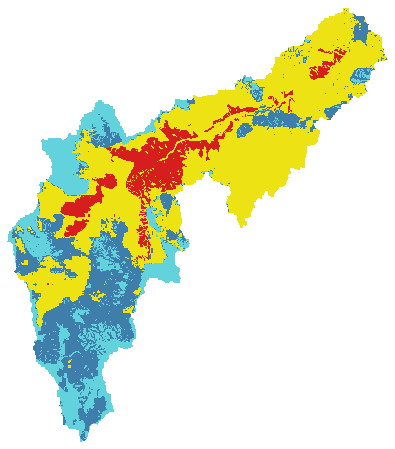

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [19]:
model.Plot_basinClean(mapa_final, cmap=model.colores_modelo)

In [3]:
import datetime
hoy = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H")
hoy_utc = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d_%H")

In [8]:
model=msi_2(ruta_historicos="/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/Mapas_nuevos/heat_historico.csv",
           ruta_estatico ="/home/hidrologia/jupyter/ModeloSusceptibilidadIncendios/AMVA/Mapas_nuevos/" )

-3.5397617692847657e+30
Usando font Avenir


<ipython-input-7-16e4e81d0a64>:99: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


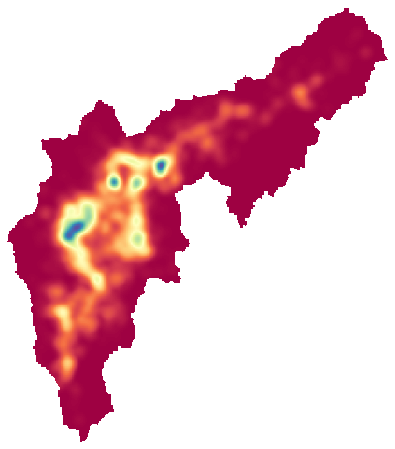

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [9]:
model.Plot_basinClean(model.mapa_historico)

In [8]:
datetime.datetime.now()+ datetime.timedelta(hours=5)

datetime.datetime(2021, 9, 17, 15, 49, 39, 405223)

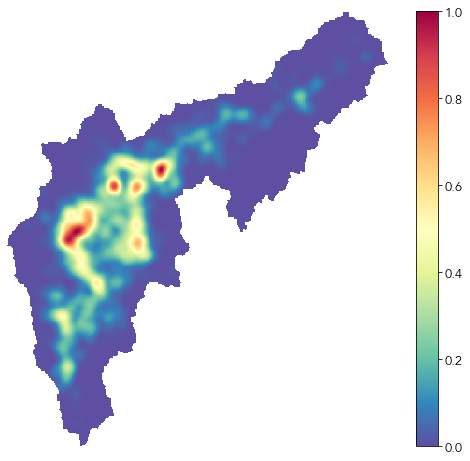

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [6]:
model.Plot_basinClean(model.mapa_historico, cmap = "Spectral_r", show_cbar= True)

# Nueva ejecución!

In [8]:
import modelo_susceptibilidad
from wmf import wmf
import numpy as np
import datetime
import pandas as pd

path = "/var/datos_hidrologia/MSI/LocalModel/Resultados_Modelo/"
fecha_dt=datetime.datetime.now()
hoy = datetime.datetime.strftime(fecha_dt, "%Y-%m-%d_%H")
hoy_utc = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d_%H")

###Genero un objeto de mi clase msi que es con el que voy a hacer todo
model = modelo_susceptibilidad.msi_2()

mapa_final, mapa_final_urban = model.generar_mapa_final()
if fecha_dt. hour ==0:
    mapa_final = pd.DataFrame(mapa_final, columns=[0])
    mapa_final.to_csv(path + hoy[:-3] +".csv")
else:
    try:
        mapas = pd.read_csv(path + hoy[:-3] +".csv", index_col =0)
    except: 
        mapas = pd.DataFrame()
    mapas = pd.concat([mapas, pd.DataFrame(mapa_final, columns=[hoy[-2:]])], axis =1)
    mapas.to_csv(path + hoy[:-3] +".csv")

/home/hidrologia/py_env/lib/python3.8/site-packages/modelo_susceptibilidad
0.08605569402708732
Usando font Avenir


/home/hidrologia/py_env/lib/python3.8/site-packages/modelo_susceptibilidad/msi_2.py:95: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


2021-10-19_15
Acumulando lluvia, esto puede tardar unos minutos
2021-10-19 19:59:00
Acumular la lluvia ha tardado: 0:02:19.849392
Se ha estimado el tiempo de sequia por celda (tiempo que la celda lleva sin superar el umbral de lluvia acumulada en milimetros, por defecto son 6mm), ver self.mapa_tiempo_sequia


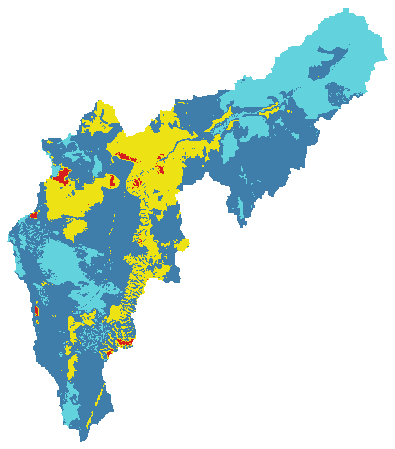

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [9]:
model.Plot_basinClean(mapa_final, cmap=model.colores_modelo)